In [159]:
import numpy as np
from dataclasses import dataclass
from itertools import product
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import subprocess

In [160]:
@dataclass
class Atom:
    r: np.ndarray
    p: np.ndarray

In [161]:
class Variables:
    def __init__(self):
        self.atoms = []

    def add_atoms(self, r):
        a = Atom(r, np.array([0, 0, 0]))
        self.atoms.append(a)

    def num_atoms(self):
        return len(self.atoms)

In [162]:
class Observer:
    def __init__(self, vars, sigma):
        self.vars = vars
        self.sigma12 = sigma**12
        self.sigma6 = sigma**6

    def kinetic_energy(self):
        ke = 0
        for a in self.vars.atoms:
            ke += 0.5 * np.linalg.norm(a.p) ** 2
        return ke / self.vars.num_atoms()

    def potential_energy(self):
        num_atoms = self.vars.num_atoms()
        pe = 0
        for i in range(num_atoms):
            for j in range(i + 1, num_atoms):
                a = self.vars.atoms[i]
                b = self.vars.atoms[j]
                r = a.r - b.r
                r2 = np.linalg.norm(r) ** 2
                pe += 4 * (self.sigma12 / r2**6 - self.sigma6 / r2**3)
        return pe / self.vars.num_atoms()

In [163]:
class MD:
    def __init__(self, L, a, T, dt, nstep, sigma):
        self.L = L
        self.a = a
        self.T = T
        self.dt = dt
        self.nstep = nstep
        self.energy = []
        self.sigma = sigma
        self.sigma12 = sigma**12
        self.sigma6 = sigma**6

    def initial_position(self, vars):
        for ix, iy, iz in product(range(self.L), repeat=3):
            r = self.a * np.array([ix, iy, iz])
            vars.add_atoms(r)
        for ix, iy, iz in product(range(self.L), repeat=3):
            r = self.a * np.array([ix, iy + 0.5, iz + 0.5])
            vars.add_atoms(r)
        for ix, iy, iz in product(range(self.L), repeat=3):
            r = self.a * np.array([ix + 0.5, iy, iz + 0.5])
            vars.add_atoms(r)
        for ix, iy, iz in product(range(self.L), repeat=3):
            r = self.a * np.array([ix + 0.5, iy + 0.5, iz])
            vars.add_atoms(r)
        return vars

    def initial_position2(self, vars):
        vars.add_atoms(self.a * np.array([0, 0, 0.1]))
        vars.add_atoms(self.a * np.array([0.5, 0, 0]))
        vars.add_atoms(self.a * np.array([0, 0, 0.9]))
        vars.add_atoms(self.a * np.array([0.5, 0, 1]))
        return vars

    def add_initial_momentum(self, vars):
        num_atoms = vars.num_atoms()
        random_momentum_x = np.random.normal(0, np.sqrt(self.T), num_atoms)
        random_momentum_y = np.random.normal(0, np.sqrt(self.T), num_atoms)
        random_momentum_z = np.random.normal(0, np.sqrt(self.T), num_atoms)
        for i, a in enumerate(vars.atoms):
            a.p = np.array(
                [random_momentum_x[i], random_momentum_y[i], random_momentum_z[i]]
            )

    def add_initial_momentum_2(self, vars):
        vars.atoms[0].p = np.array([10, 0, 0])
        vars.atoms[1].p = np.array([-10, 0, 0])
        vars.atoms[2].p = np.array([10, 0, 0])
        vars.atoms[3].p = np.array([-10, 0, 0])

    def makeconf(self, vars):
        vars = self.initial_position2(vars)
        self.add_initial_momentum_2(vars)
        return vars

    def adjust_periodic(self, r):
        for i in range(3):
            if r[i] > self.L * self.a / 2:
                r[i] -= self.L * self.a
            if r[i] < -self.L * self.a / 2:
                r[i] += self.L * self.a
        return r

    def update_position(self, vars0, vars1, f):
        vars2 = deepcopy(vars1)
        pn = vars0.num_atoms()
        for i in range(pn):
            a0 = vars0.atoms[i]
            a1 = vars1.atoms[i]
            a2 = vars2.atoms[i]
            a2.r = 2 * a1.r - a0.r + f * self.dt**2
            # a2.r = a1.r + a1.p * self.dt
        return vars2

    def calcualte_force(self, vars1):
        pn = vars1.num_atoms()
        f = np.zeros((pn, 3))
        for i in range(pn):
            for j in range(i + 1, pn):
                a1 = vars1.atoms[i]
                b1 = vars1.atoms[j]
                r = a1.r - b1.r
                # r = self.adjust_periodic(r)
                r2 = np.linalg.norm(r) ** 2
                print(i)
                print(f[i])
                print(r)
                f[i] += 24 * (2 * self.sigma12 / r2**7 - self.sigma6 / r2**4) * r
                f[j] -= 24 * (2 * self.sigma12 / r2**7 - self.sigma6 / r2**4) * r
        return f

    def update_momentum(self, vars0, vars2, f):
        pn = vars0.num_atoms()
        for i in range(pn):
            a0 = vars0.atoms[i]
            a2 = vars2.atoms[i]
            a2.p = a0.p + 2 * self.dt * f[i]

    def periodic(self, vars):
        box_size = self.L * self.a
        for a in vars.atoms:
            a.r = np.mod(a.r, box_size)  # NumPy の mod 関数を使用して周期境界条件を適用

    def dump_trajectory(self, atoms):
        with open(f"trajectory.xyz", "a") as f:
            f.write(f"{len(atoms)}\n")
            f.write("\n")
            for a in atoms:
                f.write(f"Ar {a.r[0]} {a.r[1]} {a.r[2]}\n")

    def run(self):
        subprocess.run(["rm", "trajectory.xyz"])
        vars0 = Variables()
        vars0 = self.makeconf(vars0)
        vars1 = deepcopy(vars0)
        self.dump_trajectory(vars1.atoms)
        for i in range(self.nstep):
            f = self.calcualte_force(vars1)
            vars2 = self.update_position(vars0, vars1, f)
            self.update_momentum(vars0, vars2, f)
            self.periodic(vars2)
            obs = Observer(vars2, self.sigma)
            self.energy.append([obs.kinetic_energy(), obs.potential_energy()])
            self.dump_trajectory(vars2.atoms)
            vars0 = deepcopy(vars1)
            vars1 = deepcopy(vars2)

In [164]:
params = {"L": 2, "a": 10, "T": 1, "dt": 0.001, "nstep": 1000, "sigma": 10}
md = MD(**params)
md.run()

0
[0. 0. 0.]
[-5.  0.  1.]
0
[-29618.58843612      0.           5923.71768722]
[ 0.  0. -8.]
0
[-29618.58843612      0.           5847.85028765]
[-5.  0. -9.]
1
[29618.58843612     0.         -5923.71768722]
[ 5.  0. -9.]
1
[29619.2340608      0.         -5924.87981164]
[  0.   0. -10.]
2
[-0.64562468  0.         77.02952399]
[-5.  0. -1.]
0
[0. 0. 0.]
[[ 15.   0.   1.]
 [ -5.   0. -19.]
 [ 15.   0. -19.]
 [ -5.   0.   1.]]


ValueError: non-broadcastable output operand with shape (3,) doesn't match the broadcast shape (4,3)

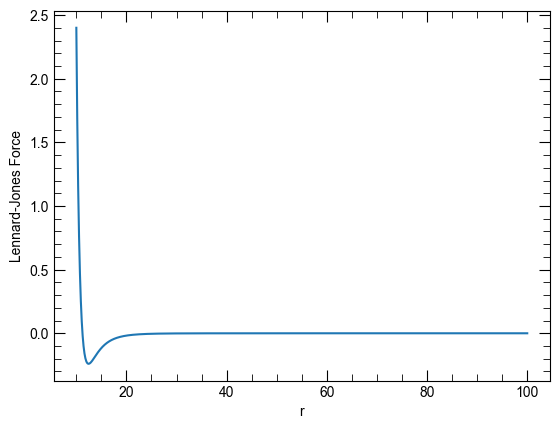

In [ ]:
sigma = 10
sigma12 = sigma**12
sigma6 = sigma**6
r = np.linspace(10, 100, 1000)
lj_force = 24 * (2 * sigma12 / r**13 - sigma6 / r**7)
fig, ax = plt.subplots()
ax.plot(r, lj_force)
ax.set_xlabel("r")
ax.set_ylabel("Lennard-Jones Force")
plt.show()

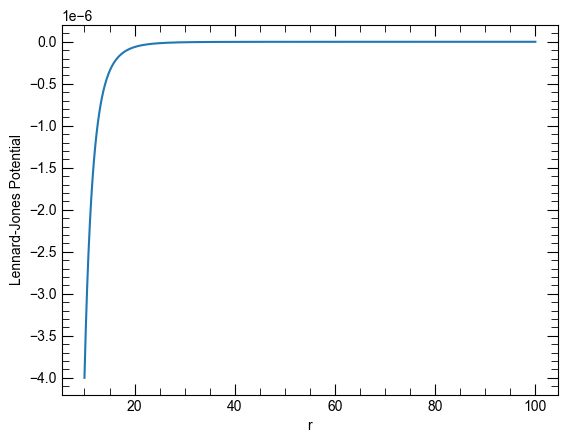

In [ ]:
lj_potential = 4 * (1 / r**12 - 1 / r**6)
fig, ax = plt.subplots()
ax.plot(r, lj_potential)
ax.set_xlabel("r")
ax.set_ylabel("Lennard-Jones Potential")
plt.show()

In [ ]:
md.energy

[[666.1621034653908, 6674.671928525349],
 [747.4807100286987, -0.2661735156765391],
 [2511.305046068952, -0.2719611156224442],
 [2108.7502589289506, -0.28341908746196676],
 [3799.0739004118664, -0.29250483925182275],
 [2853.7816081661967, -0.3039546267453116],
 [4348.752252265336, 4423.15596607602],
 [3150.0769847917973, 4639.798446107189],
 [4556.4420367789335, 4867.911440799671],
 [3261.7515422703455, 5108.140549804103],
 [4635.200590106448, 5361.187669824911],
 [3304.7944158464597, 5627.783278437209],
 [4666.160595227817, 5908.715345329796],
 [3322.031353939978, 6204.810710131307],
 [4678.80574623639, 6516.955427912477],
 [3329.181235606935, 6846.086112567855],
 [4684.129784324212, 7193.200295244447],
 [3332.2219409291506, 7559.360363575171],
 [4686.41043977063, 7945.690143890592],
 [3333.5275744239407, 8353.397400547101],
 [4687.385439620502, 8783.74831422899],
 [3334.0804693165974, 9238.1209975895],
 [4687.788219129513, 9717.940647245772],
 [3334.301650175372, 10224.789324338733],

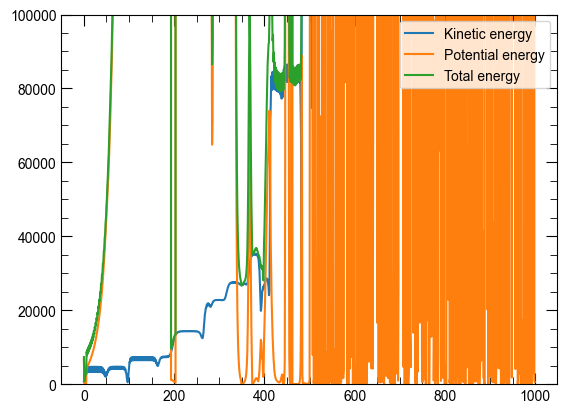

In [ ]:
fig, ax = plt.subplots()
ax.plot([e[0] for e in md.energy], label="Kinetic energy")
ax.plot([e[1] for e in md.energy], label="Potential energy")
ax.plot([e[0] + e[1] for e in md.energy], label="Total energy")
ax.legend()
ax.set_ylim(-10, 100000)
plt.show()